# Determine whether within-host variants detected in Wisconsin transmission pairs are present on the SARS-CoV2 phylogeny

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

import copy
from scipy.special import binom
import datetime as dt

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from IPython.display import HTML


try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
    
import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors
s_color = "#A5CDA2"
ns_color = "#0E7908"
stop_color = "#073C04"
fs_color = "#00357D"
fs_stop_color = "#00142F"

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [3]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [4]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-avrl.fasta"
clades_file = "/Users/lmoncla/src/ncov-WI-within-host/data/clades-file-2020-08-28.txt"
vcf_directory = "/Users/lmoncla/src/ncov-WI-within-host/data/vcfs-all/"
samples_to_ignore = ["N_transcript"]

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [5]:
all_intersection_variants.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,annotation,gene,nt_change,aa_change,strain_name,location,clade,homopolymer
0,0,orf1ab_-delTCATGTTATGGTTG_His83fs_frameshift,509.0,0.0326,0.0114,0.02200,53,frameshift,orf1ab,-delTCATGTTATGGTTG,His83fs,USA/WI-UW-67/2020,Dane County,19B,not
1,1,orf1ab_dupA_Leu293fs_frameshift,1135.0,0.0161,0.0122,0.01415,53,frameshift,orf1ab,dupA,Leu293fs,USA/WI-UW-67/2020,Dane County,19B,adjacent
2,6,orf1ab_dupT_Leu2146fs_frameshift,6696.0,0.0335,0.0968,0.06515,53,frameshift,orf1ab,dupT,Leu2146fs,USA/WI-UW-67/2020,Dane County,19B,not
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,synonymous,orf1ab,C>T,Ser2839Ser,USA/WI-UW-67/2020,Dane County,19B,not
4,11,orf1ab_dupA_Pro3851fs_frameshift,11812.0,0.0150,0.0108,0.01290,53,frameshift,orf1ab,dupA,Pro3851fs,USA/WI-UW-67/2020,Dane County,19B,not


In [6]:
print(len(all_intersection_variants))

2506


In [7]:
snvs_to_query = set(snvs_only['minor_nuc_muts'])
indels_to_query = set(indels_only['minor_nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

376
124
500


## Functions for parsing tree from nextstrain

The idea here will be to answer the following questions: 
1. What proportion of within-host variants are present on the tree? 
2. Do within-host variants have a skew towards being on internal vs. terminal branches, relative to the rest of the tree? If within-host variants are mostly deleterious, we would hypothesize that they should occur on the tree rarely and should be localized primarily to internal nodes. 
3. Are variants that are detected within-host in a given sample ever detected at consensus downstream of that sample? If the bottleneck is small and random, then I would not really expect to see this. If however, the bottleneck is really wide, then we might expect to observe this more often. The results here will need to be intergrated with Kat's actual estimates. 

In [8]:
def generate_snvs_dict_for_tree(query_list):
    snvs_on_tree = {}
    for q in query_list: 
        snvs_on_tree[q] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
    
    return(snvs_on_tree)

In [9]:
def enumerate_mutations_on_branches(tree, snvs_on_tree):    
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts: 
                        if n in snvs_on_tree:
                            snvs_on_tree[n]["branches_with_snv"].append(k.name)
                            
                            if k.branchType == "node":
                                leaves = 0 #len(k.leaves)
                                nodes = 1
                            elif k.branchType == "leaf":
                                leaves = 1
                                nodes = 0
                            
                            snvs_on_tree[n]["arose_on_tip"] += leaves
                            snvs_on_tree[n]["arose_on_internal_node"] += nodes
                            
    return(snvs_on_tree)

In [10]:
def enumerate_all_tree_muts(tree):
    
    all_snps_on_tree = {}
    total_snps = {"internal_nodes": 0, "tips":0}
    
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts:
                        if n not in all_snps_on_tree: 
                            all_snps_on_tree[n] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
                        
                        all_snps_on_tree[n]["branches_with_snv"].append(k.name)

                        if k.branchType == "node":
                            leaves = 0 #len(k.leaves)
                            nodes = 1
                        elif k.branchType == "leaf":
                            leaves = 1
                            nodes = 0

                        all_snps_on_tree[n]["arose_on_tip"] += leaves
                        all_snps_on_tree[n]["arose_on_internal_node"] += nodes
                            
                    
                    if k.branchType == "node":
                        total_snps["internal_nodes"] += len(nt_muts)
                    elif k.branchType == "leaf":
                        total_snps['tips'] += len(nt_muts)
                        
    return(all_snps_on_tree, total_snps)

## Grab the most recent json file from nextstrain, and read it in as a baltic tree object 

The current `json_translation` defined here will translate auspice v2 jsons attributes into the proper tree attributes. This will not work for auspice v1 jsons. All ncov jsons are in v2. 

In [11]:
# most recent global ncov json
# json_url='http://data.nextstrain.org/ncov_global.json'
# tree_json=json.load(csio(requests.get(json_url).content))

# or, instead we can use the wisconsin nextstrain build which incorporates global context. That might make more sense
tree_path = "/Users/lmoncla/src/ncov-WI-within-host/data/ncov_wisconsin_global-context.json"
with open(tree_path) as json_file:
    tree_json = json.load(json_file)

analysis_level = "division"

tree_object=tree_json['tree']
meta=tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

tree=bt.loadJSON(tree_object,json_translation,json_meta)


Tree height: 0.632565
Tree length: 418.027815
multitype tree
annotations present

Numbers of objects in tree: 15126 (7176 nodes and 7950 leaves)



In [12]:
#variants_to_query = all_variants_to_query
#variants_to_query = indels_to_query
variants_to_query = snvs_to_query

In [13]:
snvs_on_tree_dict = generate_snvs_dict_for_tree(variants_to_query)
snvs_on_tree_dict = enumerate_mutations_on_branches(tree, snvs_on_tree_dict)
full_tree_muts,tree_mut_counts = enumerate_all_tree_muts(tree)

In [14]:
full_tree_df = pd.DataFrame.from_dict(full_tree_muts, orient="index")
full_tree_df.reset_index(inplace=True)
full_tree_df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
full_tree_df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,-1605A,"[Sichuan/SC-YA-087/2020, Ecuador/HEE-01/2020, ...",3,1
1,-1606T,"[Sichuan/SC-YA-087/2020, Ecuador/HEE-01/2020, ...",3,1
2,-1607G,"[Sichuan/SC-YA-087/2020, Ecuador/HEE-01/2020, ...",3,1
3,-197C,[USA/IA-GMF-08606/2020],1,0
4,-197G,[NODE_0005694],0,1


In [15]:
snps_on_tips = full_tree_df['arose_on_tip'].sum()
snps_on_nodes = full_tree_df['arose_on_internal_node'].sum()
print(tree_mut_counts)

{'internal_nodes': 3879, 'tips': 9436}


In [16]:
df = pd.DataFrame.from_dict(snvs_on_tree_dict, orient="index")
df.reset_index(inplace=True)
df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
df1 = df[['snv','arose_on_tip','arose_on_internal_node']]
df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,A10558G,[],0,0
1,A10874G,"[NODE_0000867, Argentina/Heritas_HG001/2020, F...",2,1
2,A10930T,[],0,0
3,A11161G,[],0,0
4,A11451G,[Singapore/165/2020],1,0


In [17]:
# print number/fraction of SNVs that are never on the tree 
not_on_tree = len(df[(df['arose_on_tip'] == 0) & (df['arose_on_internal_node'] == 0)])
print(not_on_tree)
print(len(df))
print("the total fraction of within-host SNVs that are found on the tree is ", (len(df)-not_on_tree)/len(df))
print("the total fraction of within-host SNVs that are NOT found on the tree is ", not_on_tree/len(df))

254
376
the total fraction of within-host SNVs that are found on the tree is  0.324468085106383
the total fraction of within-host SNVs that are NOT found on the tree is  0.675531914893617


### Question 1: What fraction of variants are on the tree? 

SNVs: 33% are found on the tree, 67% are not

indels: 0% are found on the tree

overall: 25% of variants are found on the tree, 75% are not

In [18]:
# for all within-host variants added together, print the number of times they appear on tips and on internal nodes
within_host_on_tips = df['arose_on_tip'].sum()
within_host_on_nodes = df['arose_on_internal_node'].sum()
print(within_host_on_tips, within_host_on_nodes)

271 122


In [19]:
# do a Fisher's exact test, testing whether within-host variants have a different ratio of internal node to terminal
# node appearance than other mutations on the tree
import scipy
from scipy import stats
table = [[snps_on_nodes,snps_on_tips],[within_host_on_nodes,within_host_on_tips]]
odds_ratio,pvalue = stats.fisher_exact(table)

print(odds_ratio, pvalue)
print(table)

0.9131482845606989 0.43061585873617253
[[3879, 9436], [122, 271]]


I'm a little bit concerned that this result changes based on the tree I use. When I just ran this on the global nextstrain tree, I'm getting a ratio of mutations on internval vs. terminal nodes that is ~ 1:4. On the Wisconsin tree with global context, I am getting a ratio of 1:3. For both within-host variants, the ratio of mutations on internal vs. terminal nodes is ~1:3. So for one tree I am getting a significant deviation and for the other I am not. 

In [20]:
# compare with Fishers exact test 
# now run on actual data
import scipy 
from scipy import stats

p_values = {}

for index, row in df.iterrows():
    mutation = row['snv']
    on_tips = row['arose_on_tip']
    on_internal_nodes = row['arose_on_internal_node']
    
    table = [[snps_on_nodes,snps_on_tips],[on_internal_nodes,on_tips]]
    odds_ratio, p_value = (stats.fisher_exact(table))
            
    if p_value < 0.05:
        print(mutation, p_value)
        print(table)
        
    # assign stars
    if p_value > 0.01 and p_value < 0.05:
        significance = "*"

    elif p_value > 0.001 and p_value < 0.01:
        significance = "**"
        
    elif p_value > 0.0001 and p_value < 0.001:
        significance = "***"
    
    elif p_value < 0.0001:
        significance = "****"
        
    else: 
        significance = ""
            
    p_values[mutation] = {"p_value":p_value, "significance":significance}

In [21]:
print(len(df[df['arose_on_tip'] == 0]))
print(len(df[df['arose_on_tip'] > 0]))
print(len(df))

268
108
376


In [22]:
print(len(df[df['arose_on_internal_node'] == 0]))
print(len(df[df['arose_on_internal_node'] > 0]))
print(len(df))

315
61
376


In [23]:
df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,A10558G,[],0,0
1,A10874G,"[NODE_0000867, Argentina/Heritas_HG001/2020, F...",2,1
2,A10930T,[],0,0
3,A11161G,[],0,0
4,A11451G,[Singapore/165/2020],1,0


In [24]:
df_to_plot = df.copy()
df_to_plot['total_counts'] = df_to_plot['arose_on_tip'] + df_to_plot['arose_on_internal_node']
df_to_plot = df_to_plot.melt(value_vars=['arose_on_tip','arose_on_internal_node'], id_vars=['snv','total_counts'])
df_to_plot.head()

,snv,total_counts,variable,value
0,A10558G,0,arose_on_tip,0
1,A10874G,3,arose_on_tip,2
2,A10930T,0,arose_on_tip,0
3,A11161G,0,arose_on_tip,0
4,A11451G,1,arose_on_tip,1


In [25]:
# add in p-values column
p_values_df = pd.DataFrame.from_dict(p_values, orient="index")
p_values_df.reset_index(inplace=True)
p_values_df.columns = ["snv","p-value","significance"]


df_to_plot = df_to_plot.merge(p_values_df, on=['snv'])
df_to_plot.head()

,snv,total_counts,variable,value,p-value,significance
0,A10558G,0,arose_on_tip,0,1.0,
1,A10558G,0,arose_on_internal_node,0,1.0,
2,A10874G,3,arose_on_tip,2,1.0,
3,A10874G,3,arose_on_internal_node,1,1.0,
4,A10930T,0,arose_on_tip,0,1.0,


In [26]:
df_to_plot = df_to_plot[~df_to_plot['snv'].str.contains("-")]
df_to_plot = df_to_plot[df_to_plot['value'] > 0]
df_to_plot.head()

,snv,total_counts,variable,value,p-value,significance
2,A10874G,3,arose_on_tip,2,1.0,
3,A10874G,3,arose_on_internal_node,1,1.0,
8,A11451G,1,arose_on_tip,1,1.0,
12,A11983G,2,arose_on_tip,2,1.0,
72,A28881G,1,arose_on_tip,1,1.0,


In [69]:
tip_color = "#C75643"
node_color = "#545AB7"

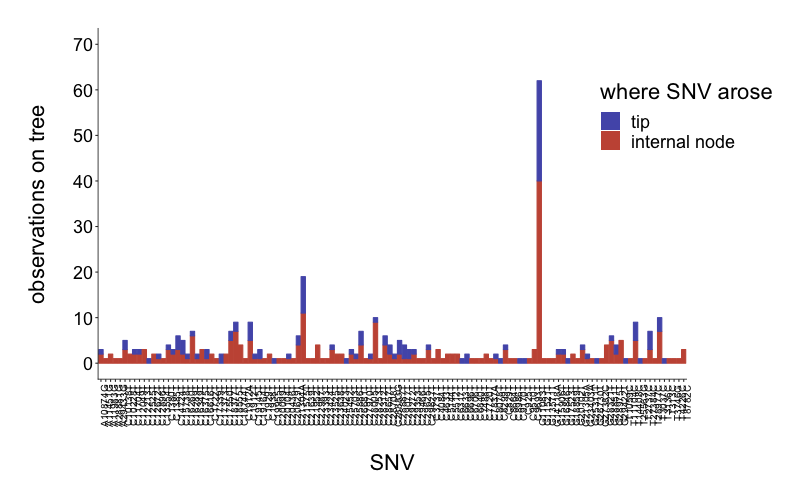

In [72]:
%%R -w 800 -h 500 -u px -i df_to_plot,tip_color,node_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

p <- ggplot(data=df_to_plot, aes(x=snv, y=value, color=variable, fill=variable)) + 
    geom_col()+
    geom_text(data=df_to_plot, aes(x=snv, y=total_counts + 0.5, label=significance), color="black",size=15)+
    labs(x="\nSNV",y="observations on tree\n")+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
    scale_y_continuous(breaks=seq(0,70,10), limits=c(0,70))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=10, colour="black", angle=90, hjust=0.95))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave("SNVs-on-global-WI-tree-2020-08-27.pdf", width = 24, height = 10, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

## Are SNVs detected multiple times within-host more likely to be detected on the tree? 

In [27]:
s = snvs_only['minor_nuc_muts'].value_counts().rename_axis('snv').reset_index(name='within_host_counts')
s.head()

,snv,within_host_counts
0,A15139C,66
1,T15167G,59
2,T15137G,40
3,T3037C,38
4,C15141A,37


In [28]:
within_vs_tree = df.copy()
within_vs_tree['total_counts'] = within_vs_tree['arose_on_tip'] + within_vs_tree['arose_on_internal_node']
within_vs_tree = within_vs_tree[['snv','total_counts']]
within_vs_tree = within_vs_tree.merge(s, on=['snv']).drop_duplicates()
within_vs_tree.head()

,snv,total_counts,within_host_counts
0,A10558G,0,1
1,A10874G,3,1
2,A10930T,0,1
3,A11161G,0,1
4,A11451G,1,1


In [29]:
def return_label(row):
    tree_counts = int(row['total_counts'])
    wh_counts = int(row['within_host_counts'])
    snv = row['snv']
    
    if tree_counts >= 10 and wh_counts >= 10:
        label = snv
    elif tree_counts >=15 or wh_counts >= 40:
        label = snv
    else:
        label = ""
        
    return(label)

In [30]:
# add in a column for a label
within_vs_tree['label'] = within_vs_tree.apply(return_label, axis=1)
within_vs_tree.head()

,snv,total_counts,within_host_counts,label
0,A10558G,0,1,
1,A10874G,3,1,
2,A10930T,0,1,
3,A11161G,0,1,
4,A11451G,1,1,


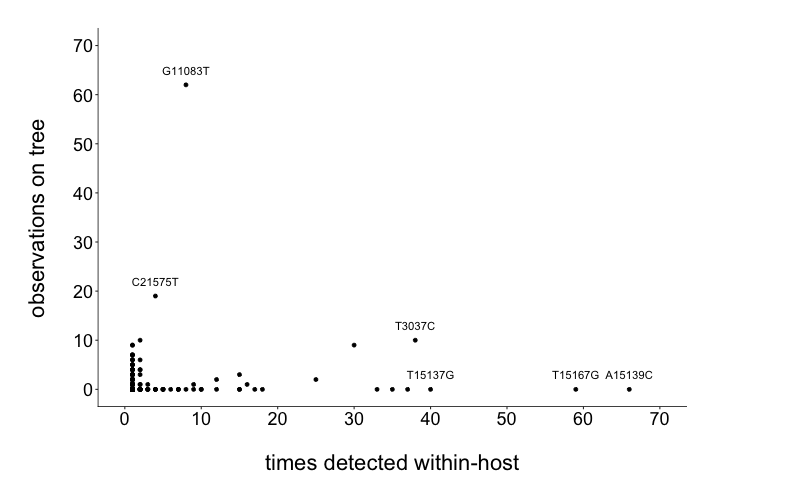

In [121]:
%%R -w 800 -h 500 -u px -i within_vs_tree  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

p <- ggplot(data=within_vs_tree, aes(x=within_host_counts, y=total_counts)) + 
    geom_point()+
    labs(x="\ntimes detected within-host",y="observations on tree\n")+
    geom_text(aes(x=within_host_counts,y=total_counts + 3,label=label), size=4)+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
    scale_y_continuous(breaks=seq(0,70,10), limits=c(0,70))+
    scale_x_continuous(breaks=seq(0,70,10), limits=c(0,70))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black"))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave("SNVs-counts-on-WI-tree-vs-wh-2020-09-03.pdf", width = 9, height = 7, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

## Do within-host variants appear downstream of the sample they were taken from?



In [122]:
def return_within_host_muts_for_branch(branch, df):
    d = df[df['strain_name'] == branch.name]
    within_host_muts = d['nuc_muts'].to_list()
    return(within_host_muts)

In [123]:
def return_within_host_muts_for_tip_name(tip_name, df):
    d = df[df['strain_name'] == tip_name]
    within_host_muts = d['nuc_muts'].to_list()
    return(within_host_muts)

In [124]:
def return_proper_parent_node(node):
    """given an internal node, traverse back up the tree to find a parental node with a 
    real branch length (basically, collapse the polytomy). This is necessary for most 
    tree software, including iqtree and treetime, which both normally atempt to resolve
    polytomies, resulting in a fully bifurcating tree with lots of very tiny branches"""
    
    #print(node, node.length)
    if abs(node.traits['node_attrs']['div'] - node.parent.traits['node_attrs']['div']) < 0.0000000001: 
        
        #print("going up 1 node")
        if node.parent !=None:
            parent_node = return_proper_parent_node(node.parent)
        
        else:
            #print("root is proper parent")
            parent_node = node
    
    else: 
        #print("current node has proper length")
        parent_node = node
    
    return(parent_node)

In [125]:
def return_nt_muts_on_branch(branch):
    nt_muts = []
    if 'branch_attrs' in branch.traits:
        if 'mutations' in branch.traits['branch_attrs']:
            if 'nuc' in branch.traits['branch_attrs']['mutations']:
                nt_muts = branch.traits['branch_attrs']['mutations']['nuc']
                            
    return(nt_muts)

In [126]:
"""Given a starting internal node, and a tip you would like to end at, traverse the full path from that node to
tip. Along the way, gather nucleotide mutations that occur along that path. Once you have reached the ending 
tip, return the list of mutations that fell along that path"""

def return_all_muts_on_path_to_tip(starting_node, ending_tip):
    
    # set an empty list of mutations and enumerate the children of the starting node; children can be tips or nodes
    muts = []
    children = starting_node.children
    
    for child in children:
        nt_muts = []
        
        """if the child is a leaf: if leaf is the target end tip, add the mutations that occur on that branch to the list
        and return the list; if leaf is not the target end tip, move on"""
        """if the child is an internal node: first, test whether that child node contains the target tips in its 
        children. child.leaves will output a list of the names of all tips descending from that node. If not, pass. 
        if the node does contain the target end tip in its leaves, keep traversing down that node recursively, 
        collecting mutations as you go"""

        if child.branchType == "leaf":
            if child.name != ending_tip:
                pass
            elif child.name == ending_tip:
                nt_muts = return_nt_muts_on_branch(child)
                for n in nt_muts:
                    muts.append(n)
                return(muts)
        
        
        elif child.branchType == "node":
            if ending_tip not in child.leaves:
                pass
            else:
                nt_muts = return_nt_muts_on_branch(child)
                for n in nt_muts:
                    muts.append(nt_muts)
                return_all_muts_on_path_to_tip(child, ending_tip)
    
    
    # flatten the list so that you don't have nested lists
    flat_list = [item for sublist in muts for item in sublist]
    return(flat_list)

In [127]:
def run_tree_test(input_tree, df_to_run):
    on_internal_nodes = 0
    has_WI_children = {}
    for k in input_tree.Objects: 

        """if the tip is one of the Wisconson sequences for which we have within-host data, pull out its division, 
        divergence value, and the divergence of its parent node"""
        if k.name in strain_names_to_query:
            has_WI_children[k.name] = []

            k_within_host_muts = return_within_host_muts_for_branch(k, df_to_run)

            if 'division' in k.traits['node_attrs']:
                division = k.traits['node_attrs']['division']['value']
                branch_length = k.traits['node_attrs']['div']
                parent_branch_length = k.parent.traits['node_attrs']['div']


                """if you lie on an internal node and are from Wisconsin, find the proper parent (collapsing very small
                branches induced by polytomy resolution) and return all children descending from that parent node"""
                if branch_length - parent_branch_length < 0.000000001:
                    on_internal_nodes += 1
                    #print(k.name, "lies on internal node")
                    #if division == "Wisconsin":
                    proper_parent = return_proper_parent_node(k.parent)
                    child_tips = proper_parent.leaves
                    #print(child_tips)

                    """next, for child, traverse the path from parent to child, enumerating mutations that fall 
                    along that path"""
                    for c in child_tips:
                        mutations = return_all_muts_on_path_to_tip(proper_parent, c)
                        for m in mutations: 
                            if m in k_within_host_muts:
                                print(k.name, c, m)
                                
                                
                    """finally, for child, if we have within-host data on that child tip, see if any match. The 
                    fuction I'm using here is slightly different, just in that is input a string instead of baltic
                    branch object"""
                    for c in child_tips:
                        if c in strain_names_to_query and c != k.name:
                            has_WI_children[k.name].append(c)
                            child_within_host_muts = return_within_host_muts_for_tip_name(c, df_to_run)
                            for m in child_within_host_muts: 
                                if m in k_within_host_muts: 
                                    #print("within-host mutation shared", k.name, c, m)
                                    pass
    return(on_internal_nodes, has_WI_children)

In [128]:
# test this out first on the Wisconsin-only build json
WI_tree_path = "/Users/lmoncla/src/ncov-WI-within-host/data/ncov_wisconsin_global-context.json"

with open(WI_tree_path) as json_file:
    WI_tree_json = json.load(json_file)
WI_tree_object=WI_tree_json['tree']
WI_meta=WI_tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':WI_meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

WI_tree=bt.loadJSON(WI_tree_object,json_translation,json_meta)


Tree height: 0.632565
Tree length: 418.027815
multitype tree
annotations present

Numbers of objects in tree: 15126 (7176 nodes and 7950 leaves)



In [129]:
strain_names_to_query = list(set(all_intersection_variants['strain_name']))
#print(strain_names_to_query)
print(len(strain_names_to_query))

103


In [130]:
df_to_run = snvs_only
tree_to_use = WI_tree

on_internal_nodes, tips_with_WI_descendants = run_tree_test(tree_to_use, df_to_run)

USA/WI-UW-118/2020 Sweden/20-51703/2020 C12049T
USA/WI-UW-118/2020 France/PL1643/2020 C12049T
USA/WI-UW-118/2020 PuertoRico/CDC-S18/2020 C8664T


In [131]:
print(on_internal_nodes, len(strain_names_to_query))

83 103


So, out of 103 tips, 83 were on internal nodes. Of those, only 1 had downstream tips with fixed variants. Even this example is not a great one I don't think. 

In [133]:
def compute_shared_variant_proportion(sample1,sample2,df):
    shared_variants = 0
    
    s1_df = df[df['strain_name'] == sample1]
    variants_in_s1 = set(s1_df['minor_nuc_muts'].tolist())
    
    s2_df = df[df['strain_name'] == sample2]
    variants_in_s2 = set(s2_df['minor_nuc_muts'].tolist())
    
    total_variants = len(variants_in_s1) + len(variants_in_s2)
    if total_variants == 0:
        proportion_shared = 0
    
    else:
        for v in variants_in_s1:
            if v in variants_in_s2:
                shared_variants += 2
            
        proportion_shared = float(shared_variants/total_variants)
        number_shared = shared_variants
            
    return(proportion_shared, number_shared)

In [134]:
# now enumerate, for tips with WI descendants, what is the probability that they share variants with one of their des?
desc_df = pd.DataFrame()
already_looked_at = []

for t in tips_with_WI_descendants:
    desc = tips_with_WI_descendants[t]
    if len(desc) > 0:
        for d in desc:
            if set([t,d]) not in already_looked_at:      
                prop_shared,number_shared = compute_shared_variant_proportion(t,d,df_to_run)
                #print(prop_shared, number_shared)
                local_dict = {"ancestor":[t],"descendant":[d],"proportion_shared":[prop_shared],"number_shared":[number_shared]}
                local_df = pd.DataFrame.from_dict(local_dict)

                desc_df = desc_df.append(local_df)
                already_looked_at.append(set([t,d]))

In [135]:
desc_df.head()

,ancestor,descendant,proportion_shared,number_shared
0,USA/WI-UW-22/2020,USA/WI-UW-96/2020,0.714286,20
0,USA/WI-UW-22/2020,USA/WI-UW-116/2020,0.444444,8
0,USA/WI-UW-22/2020,USA/WI-UW-132/2020,0.380952,8
0,USA/WI-UW-22/2020,USA/WI-UW-69/2020,0.434783,10
0,USA/WI-UW-22/2020,USA/WI-UW-67/2020,0.782609,18


In [136]:
desc_df['proportion_shared'].mean()

0.3440561234760848

In [206]:
def return_unique_clusters(desc_dict):
    
    unique_clusters = []
    sorted_desc_dict = {k: v for k, v in sorted(desc_dict.items(), key=lambda item: len(item[1]), reverse=True)}

    for t in sorted_desc_dict:
        descendants_list = sorted_desc_dict[t]

        if len(descendants_list) > 0:
            total_in_set = set(descendants_list + [t])

            # if this set of strains doesn't already exist in our unique clusters
            if len(unique_clusters) == 0:
                unique_clusters.append(total_in_set)

            elif total_in_set not in unique_clusters:

                # check to see if the current total set is a subset of an existing cluster
                is_subset = []
                for u in unique_clusters:
                    is_subset.append(total_in_set.issubset(u))

                #print(set(is_subset))
                if set(is_subset) == {False}:
                    unique_clusters.append(total_in_set)

    return(unique_clusters)

In [242]:
def return_cluster_defining_mutations(unique_clusters,df):
    cluster_id = 0
    output_df = pd.DataFrame()
    
    for cluster in unique_clusters:
        # assign a cluster id
        cluster_id += 1
        
        # subset the dataframe to only strains in that cluster
        cluster_df = df[df['strain_name'].isin(cluster)]
        
        # gather all unique within-host variants that are observed in members of that cluster
        cluster_muts = cluster_df['minor_nuc_muts'].tolist()
        non_single_cluster_muts = []
        for c in cluster_muts: 
            if cluster_muts.count(c) > 1: #len(cluster)/2:  # if found in at least half
                non_single_cluster_muts.append(c)
                
        cluster_muts = set(cluster_muts)
        non_single_cluster_muts = set(non_single_cluster_muts)
        
        # for each strain in cluster, how many of the cluster muts do they have? 
        for strain in cluster:
            shared_muts = 0
            strain_df = df[df['strain_name'] == strain]
            strain_muts = set(strain_df['minor_nuc_muts'].tolist())
            for s in strain_muts: 
                if s in non_single_cluster_muts: 
                    shared_muts += 1
            local_dict = {"strain_name":[strain],"cluster":[str(cluster_id)],"number_cluster_muts":[float(shared_muts)],
                         "total_non_single_muts_in_cluster":[len(non_single_cluster_muts)],"total_strain_in_cluster":[len(cluster)]}
            local_df = pd.DataFrame.from_dict(local_dict)
            
            
            output_df = output_df.append(local_df)

    return(output_df)

In [243]:
unique_clusters = return_unique_clusters(tips_with_WI_descendants)

cluster_df = return_cluster_defining_mutations(unique_clusters,df_to_run)
cluster_df.head()

,strain_name,cluster,number_cluster_muts,total_non_single_muts_in_cluster,total_strain_in_cluster
0,USA/WI-UW-217/2020,1,6.0,27,25
0,USA/WI-UW-246/2020,1,6.0,27,25
0,USA/WI-UW-231/2020,1,4.0,27,25
0,USA/WI-UW-306/2020,1,7.0,27,25
0,USA/WI-UW-232/2020,1,5.0,27,25


In [244]:
# write to csv
cluster_df.to_csv("/Users/lmoncla/src/ncov-WI-within-host/data/annotations-2020-08-21.csv")

### now I want to do a permutation test where I compare the proportion of variants shared within a cluster vs. between clusters 

In [249]:
def pick_2_random_numbers(list_to_sample_from):
    
    import random
    selections = random.sample(list_to_sample_from, 2)
    return(selections[0],selections[1])

In [250]:
def run_permutation_test(iterations, df_to_run):
    
    # run a bunch of times
    output_prop_list = []
    output_number_list = []

    for i in range(iterations):
        # query all strains
        list_to_query = set(df_to_run['strain_name'].tolist())
        s1,s2 = pick_2_random_numbers(list_to_query)
    
        # with those random pairs of samples, compute the proportion of snvs that are shared
        proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(s1,s2,df_to_run)
        output_prop_list.append(proportion_variants_shared)
#         output_number_list.append(number_variants_shared)
        
    # return dataframes
    output_prop_df = pd.DataFrame(output_prop_list)
    output_prop_df.columns = ['proportion_shared']
    
#     output_number_df = pd.DataFrame(output_number_list)
#     output_number_df.columns = ['number_shared']

    return(output_prop_list, output_prop_df)

In [266]:
# run on
iterations = 1000

cluster1 = cluster_df[cluster_df['cluster'] == "1"]
cluster1_df = snvs_only[snvs_only['strain_name'].isin(cluster1['strain_name'].tolist())]

cluster2 = cluster_df[cluster_df['cluster'] == "2"]
cluster2_df = snvs_only[snvs_only['strain_name'].isin(cluster2['strain_name'].tolist())]

cluster1_prop_list, cluster1_prop_df = run_permutation_test(iterations, cluster1_df)
cluster2_prop_list, cluster2_prop_df = run_permutation_test(iterations, cluster2_df)
snvs_prop_list, snvs_prop_df = run_permutation_test(iterations, snvs_only)

In [267]:
x = cluster1_prop_df
x['test'] = "cluster1"
z = cluster2_prop_df
z['test'] = "cluster2"
y = snvs_prop_df
y['test'] = "all"
combined_df = x.append(y.append(z))

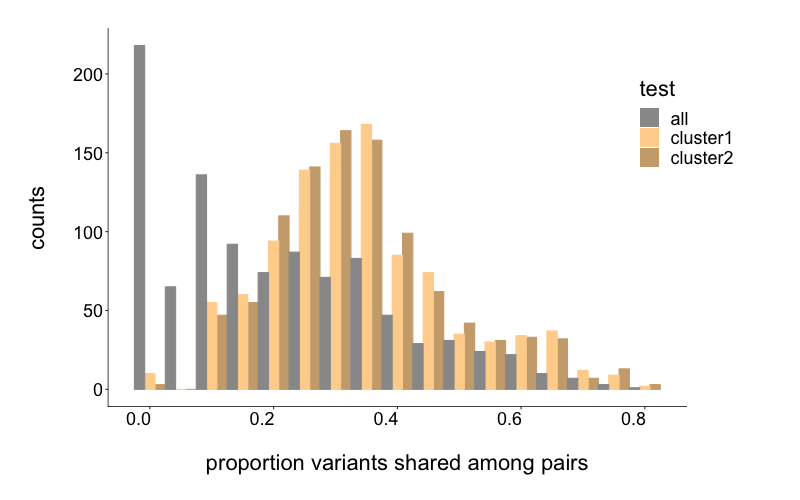

In [270]:
%%R -w 800 -h 500 -u px -i combined_df # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

p <- ggplot(data=combined_df, aes(x=proportion_shared, color=test,fill=test)) + 
    geom_histogram(binwidth=0.05, position='dodge')+
    #geom_label(data=df2, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)
    labs(x="\nproportion variants shared among pairs",y="counts\n")+
    scale_color_manual(values=c("grey60","burlywood1","burlywood3"), guide=FALSE)+
    scale_fill_manual(values=c("grey60","burlywood1","burlywood3"))+
# #     scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
# #    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black", hjust=0.95))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))

#ggsave("shared-variants-geo-permutation-test-2020-08-20-indels.pdf", width = 12, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p